# General Implementation of Grover Over Limited Search Space Using W states (Oracle 2)
---

In [1]:
import networkx as nx
import numpy as np
import math
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import warnings
from random import choice, randint
import os
import re
import itertools
from IPython.display import IFrame
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram
import csv
import copy
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0]

In [ ]:
#A function to display results in a ket format (as descripted in arXiv:1903.04359v1)
def Measurement(quantumcircuit, *args, **kwargs): 
	#Displays the measurement results of a quantum circuit 
	p_M = True
	S = 1
	ref = False
	NL = False
	if 'shots' in kwargs:
		S = int(kwargs['shots'])
	if 'return_M' in kwargs:
		ret = kwargs['return_M']
	if 'print_M' in kwargs:
		p_M = kwargs['print_M']
	if 'column' in kwargs:
		NL = kwargs['column']
	M1 = execute(quantumcircuit, M_simulator, shots=S).result().get_counts(quantumcircuit)
	M2 = {}
	k1 = list(M1.keys())
	v1 = list(M1.values())
	for k in np.arange(len(k1)):
		key_list = list(k1[k])
		new_key = ''
		for j in np.arange(len(key_list)):
			new_key = new_key+key_list[len(key_list)-(j+1)]
		M2[new_key] = v1[k]
	if(p_M):
		k2 = list(M2.keys())
		v2 = list(M2.values())
		measurements = ''
		for i in np.arange(len(k2)):
			m_str = str(v2[i])+'|'
			for j in np.arange(len(k2[i])):
				if(k2[i][j] == '0'):
					m_str = m_str + '0' 
				if(k2[i][j] == '1'):
					m_str = m_str + '1'
				if( k2[i][j] == ' ' ):
					m_str = m_str +'>|'
			m_str = m_str + '>   '
			if(NL):
				m_str = m_str + '\n'
			measurements = measurements + m_str
		#print(measurements)
		return measurements
	if(ref):
		return M2

# Get graph from list of edges
---

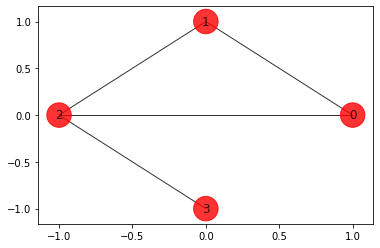

In [3]:
#Produce a graph from a list of edges
#The edges list must be ordered as in, all edges from node 0 then 1 then 2 and so on...
G = nx.Graph()
default_axes = plt.axes(frameon=True)
#[(0, 1), (0, 3), (1, 3), (1, 2)] Origonal
#[(0, 1), (2, 3), (1, 3), (1, 2)] Test
#edges = [(4,1),(4,2),(4,3),(1,2),(1,3),(1,0),(2,3),(2,0)]
edges = [(0, 1), (2, 3), (0, 2), (1, 2)]#The graph we used so far
#1- Find number of nodes based on a given list of edges
#edges =[(0, 1), (1, 2), (1, 3)]

n_nodes = len(set(itertools.chain.from_iterable(edges))) 

#2- Draw graph based on number of nodes and edges
G.add_edges_from(edges)
G.add_nodes_from(range(n_nodes))
G.add_edges_from(edges)
colors = ['r' for node in G.nodes()]
pos = nx.shell_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

# Define the Wn gate
---

In [4]:
#Implementation of W state as described in arXiv:1807.05572v1
def cg (qcir,cQbit,tQbit,theta):
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u3(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u3(-theta_dash,0,0,tQbit)
    #oq.Wavefunction(qc)
    return qcir


def wn (qcir,qbits): 
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = cg(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
            #print(p)
    return qcir,qbits

# State Preparation
---

In [5]:
k = 3 #clique size
sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state")
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()
print(sub_cir.decompose().size())
state_prep_size = sub_cir.decompose().size()-1
print("total number of operations in the circuit.")
print(sub_cir.size())
print("depth of circuit (number of ops on the critical path)")
print(sub_cir.depth())
print("a breakdown of operations by type")
print(sub_cir.count_ops())

17
total number of operations in the circuit.
17
depth of circuit (number of ops on the critical path)
14
a breakdown of operations by type
OrderedDict([('u3', 6), ('cx', 6), ('x', 5), ('barrier', 4)])


# Define cz gate
---

In [6]:
def cnz(qc, num_control, node, anc):
    """
    num_control :  number of control qubit of cnz gate
    node :             node qubit
    anc :               ancillaly qubit
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

# The Diff operator
---

In [7]:
def grover_diff(qc, nodes_qubits,edge_anc,edge_flag,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits)  

# The Oracle
---

In [8]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    #print(bin_k)
    #print(qubits)
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])

In [9]:
def inc(n): #Quantum increment circuit
    # n >> size of increment circuit
    a = QuantumRegister(n)  
    qc = QuantumCircuit(a,name="inc")
    print(len(a))
    if len(a)==2:
        qc.cx(a[0],a[1])
        qc.x(a[0]) 
    elif len(a)==3:
        qc.ccx(a[0],a[1],a[2])
        qc.cx(a[0],a[1])
        qc.x(a[0]) 
    elif len(a)>3:
        anc = QuantumRegister(1)
        qc.add_register(anc)
        for i in range(len(a)-1,-1,-1):
            if i > 0:
                control_qubits = a[:i]
                qc.mct(control_qubits,a[i],anc[:]) 
            elif i == 0:
                qc.x(a[i])
    else:
        raise Exception("Unvalid Quantum Register!")
    return qc

In [10]:
inc_k = len(bin(k)[2:])
incg = inc(inc_k).to_gate()
incgc = incg.control()
rev = incgc.inverse()

2


In [11]:
def oracle(k,n_nodes, edges, qc, nodes_qubits, edge_anc,edge_flag, ancilla, neg_base):
    #1- edge counter
    #forward circuit
    qc.barrier()
    needed_qubits = len(bin(k)[2:])
    for i in range(0, len(edges)):
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_flag[0])
        if needed_qubits>3:
            args = [edge_flag[0]]+edge_anc[:]+ancilla[:n-2]
        else:
            args = [edge_flag[0]]+edge_anc[:] 
        qc.append(incgc,qargs=args)
    #----------------------------------------------------------------------------------------------------------
    #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[n_nodes-3],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------
    #Reverse edge count
    for i in range(len(edges)-1,-1,-1):  
        if needed_qubits>3:
            args = [edge_flag[0]]+edge_anc[:]+ancilla[:n-2]
        else:
            args = [edge_flag[0]]+edge_anc[:] 
        qc.append(rev,qargs=args)  
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_flag[0])
    qc.barrier()

# The Algorithm
---

In [12]:
# Grover algo function
def grover(x,k,n_nodes,stat_prep,inv_stat_prep): # X >> Number of iterations
    N = 2**n_nodes  # for optimal iterations count
    P = len(bin(k)[2:])
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(P, name='edge_anc')
    edge_flag = QuantumRegister(1,name='edge_flag')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(1, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc,edge_flag, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = round(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(x):
        qc.barrier()
        oracle(k,n_nodes, edges, qc, nodes_qubits, edge_anc,edge_flag, ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,edge_flag,ancilla,stat_prep,inv_stat_prep)
    return qc, nodes_qubits, edge_anc, edge_flag, ancilla, neg_base, class_bits, tri_flag

# For different iterations
---

In [14]:
l = [] #a list to store different number of iterations results
N = 2**n_nodes # for iterations count
data =[]
iterations = round(math.pi/4*math.sqrt(N))
for i in range(1,2): #Observing the algorithm behaviour for different iterations, optimal iternation is 1
    qc, nodes_qubits, edge_anc, edge_flag, ancilla, neg_base, class_bits, tri_flag = grover(i,k,n_nodes,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    #Executing circuit and show results
    ex = execute(qc, M_simulator, shots = 5000)
    res = ex.result()
    M = res.get_counts(qc)
    #printing measurements results
    s = Measurement(qc,shots=5000)   
    pattern = "\d+\|\d{4}\>"
    res = re.findall(pattern,s)
    dct = {}
    for item in res: #Observing the algorithm behaviour for different iterations, optimal iternation is 1
        if item[item.index("|"):] not in dct.keys():
            dct[item[item.index("|"):]] = int(item[:item.index("|")]) 
        else:
            dct[item[item.index("|"):]] += int(item[:item.index("|")]) 
    l.append(dct)
    print("===========================")
    print("at "+str(i)+" Iterations")
    print(dct)
    print("total number of operations in the circuit.")
    print(qc.size())    
    print("depth of circuit (number of ops on the critical path)")
    print(qc.depth())
    print("number of qubits in the circuit")
    print(len(qc.qubits))
    print("a breakdown of operations by type")
    print(qc.decompose().count_ops())
    data.append([str(i),str(qc.size()),str(qc.depth()),str(len(qc.qubits)),qc.count_ops()])

at 1 Iterations
{'|1110>': 5000}
total number of operations in the circuit.
39
depth of circuit (number of ops on the critical path)
29
number of qubits in the circuit
10
a breakdown of operations by type
OrderedDict([('cx', 145), ('u3', 75), ('t', 52), ('tdg', 39), ('u1', 32), ('h', 28), ('barrier', 17), ('x', 15), ('ccx', 8), ('measure', 4), ('u2', 1)])


# Results
---

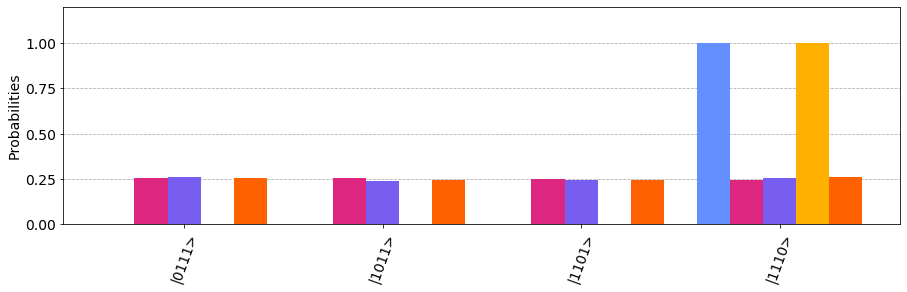

In [13]:
#Comparing 5 iterations
plot_histogram(l, bar_labels=False,figsize=(15, 4))

# Adding Noise
---

In [12]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
import math
simulator = QasmSimulator()

In [13]:
def noise_func(n,T1in,T2in):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(T1in, 10e3, n) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(T2in, 10e3, n)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                      for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                  for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(n):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(n):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

    #print(noise_thermal)
    return noise_thermal

In [34]:
k = 3
sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state")
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()

In [14]:
l = [] #a list to store different number of iterations results
N = 2**n_nodes # for iterations count
data =[]
ss =[]
noise_thermal = None
iterations = round(math.pi/4*math.sqrt(N))
for i in range(1,6):
    qc, nodes_qubits, edge_anc, edge_flag, ancilla, neg_base, class_bits, tri_flag = grover(i,k,n_nodes,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    #Executing circuit and show results
    if noise_thermal is None:
        T1 = 500e3
        T2 = 500e3
        noise_thermal = noise_func(len(qc.qubits),T1,T2)
    ex = execute(qc, simulator, basis_gates=noise_thermal.basis_gates, noise_model=noise_thermal)
    #ex = execute(qc, M_simulator, shots = 5000)
    res = ex.result()
    M = res.get_counts(qc)
    ss.append(M)
    #printing measurements results
    s = oq.Measurement(qc,shots=5000)   
    pattern = "\d+\|\d{4}\>"
    res = re.findall(pattern,s)
    dct = {}
    for item in res:
        if item[item.index("|"):] not in dct.keys():
            dct[item[item.index("|"):]] = int(item[:item.index("|")]) 
        else:
            dct[item[item.index("|"):]] += int(item[:item.index("|")]) 
    l.append(dct)